# Análise de dados e construção de modelo de machine learning para análise de fake news


- importando libs para análise de dados

In [51]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import re
import collections
import nltk
import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Importando o arquivo com todas as notícias

In [2]:
todas_noticias = pd.read_csv('datasets/todos_os_dados.csv')
todas_noticias.target.unique()

array(['falso', 'verdadeiro'], dtype=object)

## Limpeza dos dados (Feature engineering)

- Para esta análise de dados não precisaremos do link da imagem nem da origem da notícia
- Vamos trabalhar apenas com a coluna `info` e a coluna `target`

In [3]:
todas_noticias = todas_noticias[['info', 'target']]
todas_noticias.sample(5)

,info,target
9686,“Exemplo: Dória fechou os restaurantes para ev...,falso
703,Primeira aparição do petista Chico Buarque na ...,falso
1220,Impeachment corre o risco de ser anulado pelo ...,falso
314,"Correia: Em 2013, o PSDB mineiro barrou a CPI...",falso
4283,Os negócios secretos da Coreia do Norte. Apesa...,verdadeiro


**Renomeando:** Serão renomeadas o nome das colunas para português, estamos trabalhando com dados em português e o código também segue o padrão português, também para facilitar o entendimento de quem irá consumir este notebook

In [4]:
colunas = {'info': 'texto', 'target': 'classificacao'}
todas_noticias.rename(columns=colunas, inplace=True)

### Total de notícias verdadeiras:

In [5]:
total_verdadeiras = len(todas_noticias[todas_noticias.classificacao == 'verdadeiro'])
total_verdadeiras

5014

### Total de notícias falsas

In [6]:
total_falsas = len(todas_noticias[todas_noticias.classificacao == 'falso'])
total_falsas

7497

### Total de notícias

In [7]:
total = len(todas_noticias)
total

12511

- Verificar se existem dados vazios ou inválidos nas colunas info e target

A função assert joga um erro se encontrar algum dado 

In [8]:
num_texto_null = len(todas_noticias[todas_noticias['texto'].isnull()])
num_texto_vazio = len(todas_noticias[todas_noticias['texto'].isna()])
assert  num_texto_null + num_texto_vazio == 0

In [9]:
num_classificacao_null = len(todas_noticias[todas_noticias['classificacao'].isnull()]) 
num_classificacao_vazio = len(todas_noticias[todas_noticias['classificacao'].isna()])
assert num_classificacao_vazio + num_classificacao_null == 0

### Normalizando os dados

- Passar todos os dados para lowercase para que não haja distinção entre maíusculo e minúsculo
- Remover acentuação, aspas e possíveis caracteres especiais

In [10]:
todas_noticias.texto = todas_noticias.texto.map(lambda x: x.lower())

### Removendo acentuação 

- usando a lib `unidecode` remove a acentuação das palavras

In [11]:
todas_noticias.texto = todas_noticias.texto.map(lambda x: unidecode(x))

### Removendo caracteres especiais

- Expressões regulares podem ser usadas para remover caracteres especiais


In [12]:
todas_noticias.texto = todas_noticias.texto.map(lambda x: re.sub('[\W_0-9]+', ' ', x))

## Contando as palavaras

- Montando um contador geral 
- Montando um contador de palavras comuns para fake news
- Montando um contador de palavras comuns para notícias verdadeiras


In [13]:
verdadeiro_count = collections.Counter()
falso_count = collections.Counter()
todas_count = collections.Counter()

## Montando a contagem das palavras

- fazendo a contagem

In [14]:
for index, row in todas_noticias.iterrows():
    noticia = row['texto'].split(' ')
    if row['classificacao'] == 'verdadeiro':
        verdadeiro_count.update(noticia)
    else:
        falso_count.update(noticia)
    todas_count.update(noticia)

### Criando cópia dos contadores verdadeiros e falsos

- Vamos salvar uma cópia dos contadores de palavras para ambas as classes
para podermos analisar se as stop words estão trazendo alguma vantagem ou
desvantagem para o modelo




    

In [15]:
verdadeiro_count_plot = verdadeiro_count.copy()
falso_count_plot = falso_count.copy()

## Calculando a razão

- Com o cálculo da razão podemos ter a noção de quanto uma palavra ocorre
no lado positivo em relação ao negativo. 

- O calculo se dá por:


**razao = ocorrencia_palavra_lado_positivo / (ocorrencia_da_palavra_lado_negativo +1)**

- Palavras que ocorrem no muito mais no lado positivo do que no lado negativo
tendem a apresentar uma razão com alto valor. Já palavras que ocorrem muito no lado negativo
terão valor de razão bem pequeno. Já para stop words o que se espera é que o valor
fique próximo de 1, visto que a quantidade de ocorrência da mesma pode ser próxima para ambos
os lados.

In [16]:
razao_falso_verdadeira = collections.Counter()
for word, count in list(todas_count.most_common()):
    if count > 10:
        razao = verdadeiro_count[word] / float(falso_count[word] + 1)
        razao_falso_verdadeira[word] = razao

### Calculando log da razão

- Os valores de razão podem ficar muito dispersos, podendo palavras terem valores de razão muito distantes, desta maneira o cálculo do logarítimo vai aproximar os valores, facilitando a plotagem de distribuição

- Os valores de razão maiores devem ter um log variando mais próximo dos valores de 1 a 5
- Os valores mais próximos de 1 que pode ser onde as stop words, ficariam com 0 (pois o log de 1 é 0)
- E os valores muito pequenos de razão ficariam na ponta oposta, 
como valores negatívos entre -1 e -5

- Vale ressaltar que vamos manter as stopwords na distribuição para observar o comportamento

In [17]:
np.seterr(divide = 'ignore') 
razao_falso_verdadeira_log = {k: np.log(v) for k, v in razao_falso_verdadeira.items()}

### Obtendo a lista de stopwords a partir da biblioteca nltk

- A biblioteca nltk nos permite fazer o download de uma lista de palavras vazias (stop words) de várias linguas, no caso deste trabalho a lingua portuguesa.

In [18]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/willian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Removendo stopwords da contagem de palavras

- Vamos remover as stop words, da contagem das classes (lembrando que temos uma cópia destes dados)

- primeiramente serão padronizadas as stop words de acordo com o restante das outras palavaras



In [19]:
palavras_comuns = [unidecode(palavra) for palavra in stopwords]

- Executando a remoção

In [20]:
for palavra in palavras_comuns:
    if palavra in list(falso_count):
        del falso_count[palavra]
    if palavra in list(verdadeiro_count):
        del verdadeiro_count[palavra]   

## Criando o vocabulário

- O vocabulário é a lista de palavaras únicas que apareceram nas notícias verdadeiras e falsas. 

In [21]:
vocabulario = set(todas_count.keys())
len(vocabulario)

82080

## Visualização de dados

- Nesta parte faremos visualização dos dados e através das visualizações podemos formar hipóteses

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Proporção de notícias Falsas x Verdadeiras

- Qual a porcentagem que temos da relação entre notícias falsas e verdadeiras


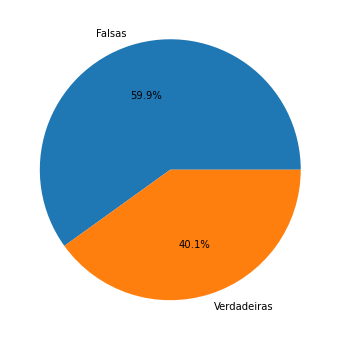

In [23]:
#Porcentagem falsa
porcentagem_falsa = total_falsas / total * 100
porcentagem_verdadeira = total_verdadeiras / total * 100

fatias = [porcentagem_falsa, porcentagem_verdadeira]
labels = ['Falsas', 'Verdadeiras']
fig1 = plt.subplot()
ax = fig1.pie(fatias, labels=labels, autopct='%1.1f%%')
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

plt.show()

### Ponto de atenção:

- Temos uma proporção de quase 20% a mais para notícias falsas.

## Estatísticas gerais do dataset

- vamos calcular a média e mediana para as notícias presentes no dataset


In [24]:
## Media
falsas = todas_noticias[todas_noticias.classificacao == 'falso']
somatorio_falsas = falsas.texto.map(lambda x: len(x))
media_falsas = somatorio_falsas.mean()

## Media
verdadeiras = todas_noticias[todas_noticias.classificacao == 'verdadeiro']
somatorio_verdadeiras = verdadeiras.texto.map(lambda x: len(x))
media_verdadeiras = somatorio_verdadeiras.mean()

#Mediana
mediana_falsas = somatorio_falsas.median()

#Mediana
mediana_verdadeiras = somatorio_verdadeiras.median()

print(f'Média de tamanho (em cacateres) de notícias verdadeiras {round(media_verdadeiras)}')
print(f'Média de tamanho (em cacateres) de notícias falsas {round(media_falsas)}')
print(f'Mediana de tamanho (em caracteres) de notícias verdadeiras {round(mediana_verdadeiras)}')
print(f'Mediana de tamanho (em caracteres) de notícias falsas {round(mediana_falsas)}')

Média de tamanho (em cacateres) de notícias verdadeiras 4635
Média de tamanho (em cacateres) de notícias falsas 585
Mediana de tamanho (em caracteres) de notícias verdadeiras 4026
Mediana de tamanho (em caracteres) de notícias falsas 300


- Se observarmos as notícias verdadeiras tem maior tamanho, apesar de
terem menor quantidade.
- Não é notada a presença de outliers modificando muito a média, visto
que a o média e mediana estão bem próximas

## Analisando ocorrência de palavras mais comuns

- Analisando as palavras mais comuns de forma geral 
- Primeiramente para facilitar o trabalho criamos um dataset
utilizando o resultado da função `most_common` provida pela lib `Counter` que já retorna o resultado do maior para o menor.


In [25]:
df_most_commom = pd.DataFrame(todas_count.most_common(), columns=['word', 'count'])

- Agora vamos plotar um gráfico das palavras mais comuns em geral,
temos o seguinte resultado:

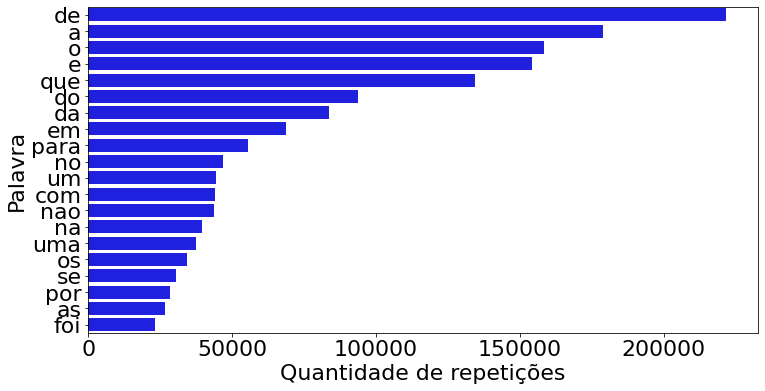

In [26]:
ax = sns.barplot(y='word', x='count', data=df_most_commom[:20],  color = 'blue')
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})
ax.set(xlabel='Quantidade de repetições', ylabel='Palavra')
plt.show()

- Repare que o resultado são apenas palavras vazias (stop words)
- Elas fazem bastante volume no geral

### Agora vamos observar por classe

- Vamos utilizar o cópia que temos da contagem de palavras em notícias,
verdadeiras que ainda possuem a presença de stop words

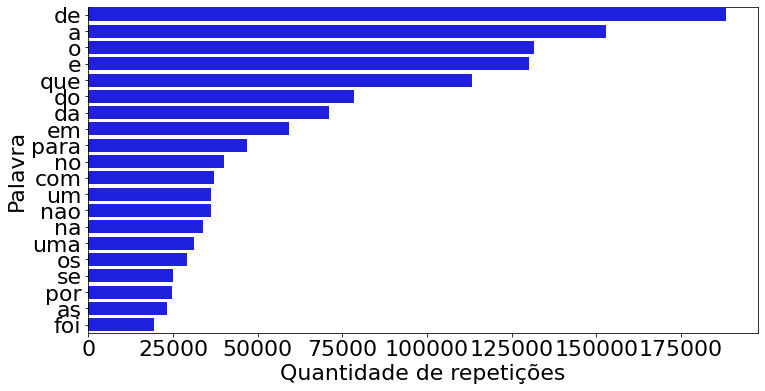

In [27]:
df_verdadeiro_count = pd.DataFrame(verdadeiro_count_plot.most_common(),columns=['word','count'])
ax = sns.barplot(y='word', x='count', data=df_verdadeiro_count[:20],  color = 'blue')
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})
ax.set(xlabel='Quantidade de repetições', ylabel='Palavra')
plt.show()

- Percebe-se que as stop words são predominantes no caso de notícias Verdadeiras

- Vamos observar se o mesmo acontece com notícias Falsas

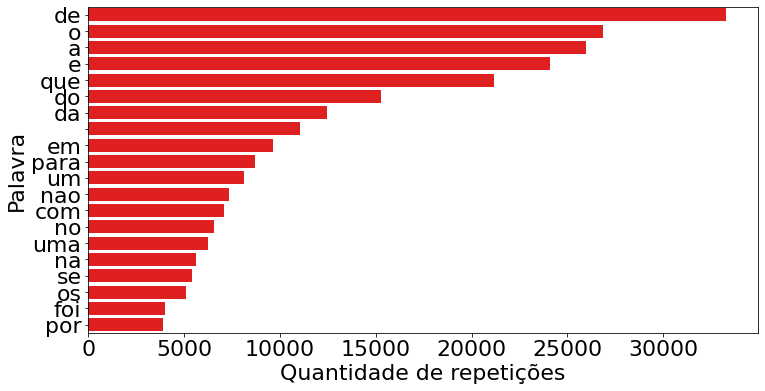

In [28]:
df_falso_count = pd.DataFrame(falso_count_plot.most_common(), columns=['word', 'count'])
ax = sns.barplot(y='word', x='count', data=df_falso_count[:20], color='red')
plt.gcf().set_size_inches(12,6)
ax.set(xlabel='Quantidade de repetições', ylabel='Palavra')
plt.rcParams.update({'font.size': 22})

- Percebe-se que são praticamente as mesmas palavras dominam para ambas as classes
- Desta maneira fica difícil fazermos uma análise
- Para a análise seguinte vamos plotar os gráficos sem a presença das stop words, para analisarmos o comportamento

- Abaixo plotagem do mesmo gráfico agora sem a presença de stop words em notícias verdadeiras:

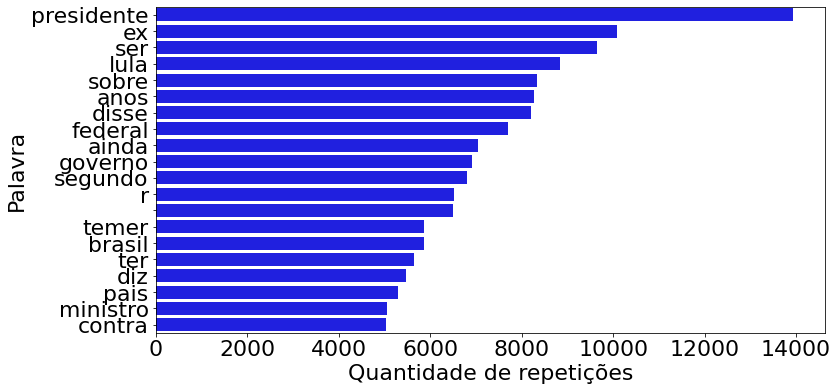

In [29]:
df_verdadeiro_mc_whithout_sw = pd.DataFrame(verdadeiro_count.most_common(), columns=['word', 'count'])
ax = sns.barplot(y='word', x='count', data=df_verdadeiro_mc_whithout_sw[:20], color='blue')
plt.gcf().set_size_inches(12,6)
ax.set(xlabel='Quantidade de repetições', ylabel='Palavra')
plt.rcParams.update({'font.size': 22})

- Observe que agora as palavras que aparecem denotam um certo contexto para a notícia
- Agora vamos observar abaixo como fica o gráfico de notícias Falsas sem a presença de stop word:

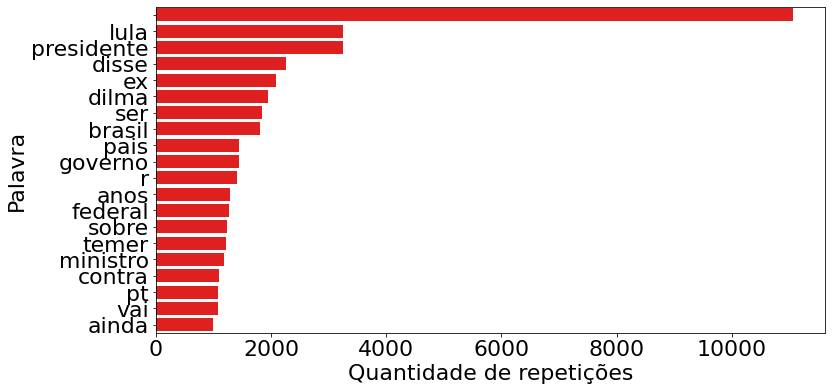

In [30]:
df_falso_mc_whithout_sw = pd.DataFrame(falso_count.most_common(), columns=['word', 'count'])

ax = sns.barplot(y='word', x='count', data=df_falso_mc_whithout_sw[:20], color='red')
plt.gcf().set_size_inches(12,6)
ax.set(xlabel='Quantidade de repetições', ylabel='Palavra')
plt.rcParams.update({'font.size': 22})

- Repare que também podemos ter um contexto do que se é mencionado nas notícias Falsas.

- Uma visualização muito comum em é a nuvem de palavras, é uma forma interessante de mostrar palavras que ocorrem bastante, mas que não cabem em um gráfico de barras.

- A nuvem de palavras da enfase nas palavras mais repetidas deixando-as maiores, vai reduzindo de tamanho as outras palavras que ocorreram bastante mas com menor intensidade.


In [38]:
from wordcloud import WordCloud, ImageColorGenerator

- Abaixo a nuvem de palavras para notícias verdadieras

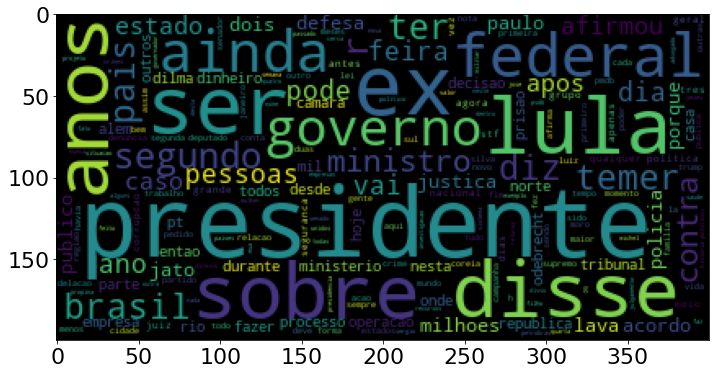

In [39]:
verdadeiro_cloud = WordCloud(stopwords=stopwords).generate_from_frequencies(verdadeiro_count)

plt.imshow(verdadeiro_cloud)
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

- Abaixo a nuvem de palavras para notícias falsas.

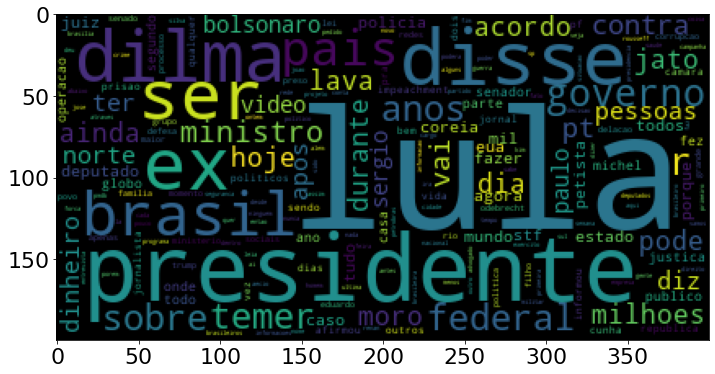

In [40]:
falso_count_cloud = WordCloud(stopwords=stopwords).generate_from_frequencies(falso_count)

plt.imshow(falso_count_cloud)
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

- Agora que temos noção do contexto, podemos começar a avalidar a hipótese de que 
a ocorrência de uma determinadas palavras pode ter relação com a classificação da notícia.

## Observando a densidade e concentração das palavras

- A partir de agora analisar a concentração das palavras
- Vamos utilizar os valores de razão calculados anteriormente neste documento.
- Testar a hipótese citada acima, verificar a tendência para cada classe.
- Vamos construir um histograma para avaliar a distribuição das palavras através da razão

- Antes de criar a visualização vamos padronizar e organizar os valores
- Criaremos um DataFrame com os valores de razão.
- Renomearemos a coluna de `0` para razão, para ficar mais claro o dado que estamos trabalhando
- Substituiremos os valores infinitos para `not a number` e em seguidas fazemos a remoção dos mesmos.
- Convertemos todos os valores de texto para float64 para trabalhar com a plotagem dos valores.


In [56]:
s  = pd.Series(razao_falso_verdadeira_log,index=razao_falso_verdadeira_log.keys()).to_frame()
s.rename(columns = {0: 'razao'}, inplace=True)
s.head()

s.replace([np.inf, -np.inf], np.nan, inplace=True)
s.dropna(inplace=True)
s['razao'] = s['razao'].map(lambda x: np.float64(x))


- Agora vamos fazer a plotagem do histograma da razão

[Text(0.5, 0, 'Razão'), Text(0, 0.5, 'Densidade')]

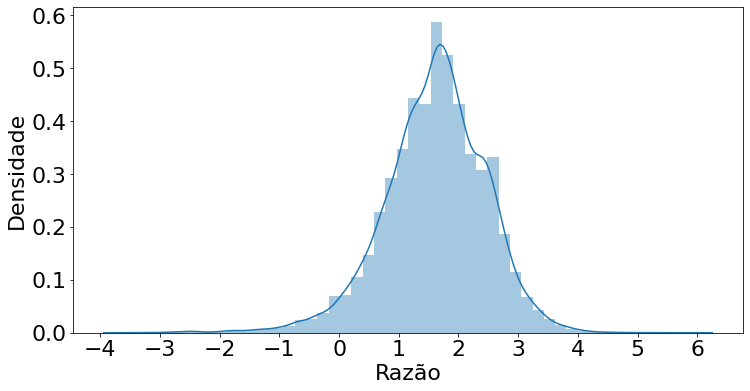

In [57]:
raz = sns.distplot(s['razao'])
plt.gcf().set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})
raz.figure.set_size_inches(12,6)
raz.set_xticks(range(-4,7))
raz.set(xlabel='Razão', ylabel='Densidade')

### Analisando as distribuições

- Vamos analisar os intervalos presentes
- Encontrar o intervalo onde se encontram as stop words
- E quais os intervalos para os notícias verdadeiras e falsas
- Primeiramente separamos em dataframes específicos por classe pois até o momento todas as razões se encontram em apenas um DataFrame sendo ele `razao_falso_verdadeira_log`



Abaixo vamos criar para a classe verdadeira

In [96]:
verdadeiras = []
for nome, cont in verdadeiro_count.items():
    if nome in razao_falso_verdadeira_log.keys():
        ratio = razao_falso_verdadeira_log[nome]
        if not np.isinf(ratio):
            verdadeiras.append({'palavra':nome, 'cont': cont, 'ratio': ratio})
verdadeiras = pd.DataFrame(verdadeiras)

Agora o DataFrame de razões das notícias falsas

In [98]:
falsas = []
for nome, cont in falso_count.items():
    if nome in razao_falso_verdadeira_log.keys():
        ratio = razao_falso_verdadeira_log[nome]
        if not np.isinf(ratio):
            falsas.append({'palavra':nome, 'cont': cont, 'ratio': ratio})
falsas = pd.DataFrame(falsas)

E por ultimo vamos criar um DataFrame de classe neutra apenas com as razões das stop words

In [100]:
stop = []
for nome in stopwords:
    if nome in razao_falso_verdadeira_log.keys():
        ratio = razao_falso_verdadeira_log[nome]
        cont = todas_count[nome]
        if not np.isinf(ratio):
            stop.append({'palavra':nome, 'cont': cont, 'ratio': ratio})
stop = pd.DataFrame(stop)

Agora vamos buscar os ranges, pegando a menor razão e a maior razão para cada classe

In [111]:
print('Stop Words - razão mínima: {:.2f} e valor máximo de: {:.2f}'
      .format(min(stop['ratio']), max(stop['ratio'])))

print('Verdadeiras - razão mínima: {:.2f} e valor máximo de: {:.2f}'
      .format(min(verdadeiras['ratio']), max(verdadeiras['ratio'])))

print('Falsas - razão mínima: {:.2f} e valor máximo de: {:.2f}'
      .format(min(falsas['ratio']), max(falsas['ratio'])))

Stop Words - razão mínima: -0.18 e valor máximo de: 2.84
Verdadeiras - razão mínima: -3.58 e valor máximo de: 5.89
Falsas - razão mínima: -3.58 e valor máximo de: 4.72


- Como podemos observar as stop words ficam mais concentradas 
no centro da distrbuição 
- As notícias Verdadeiras tem palavras variando dentro de toda a distrbuição 
e indo bastante para o lado direito do histograma
- As notícias Falsas tem palavras que também variam por toda a distrbuição, porém não chegam a ponta extrema a direita do histogramarama

- Podemos criar gráficos sobrepostos para podermos comparar onde estão as diferenças entre as classes verdadeiras e falsas

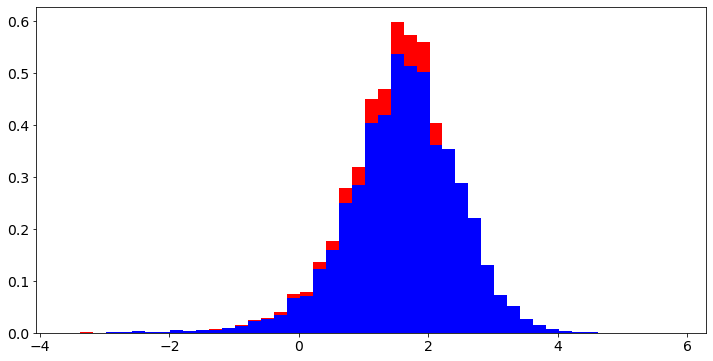

In [139]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

ax1.hist(falsas['ratio'],density=True,bins=razao_range, color = 'red')
ax1.hist(verdadeiras['ratio'],density=True,bins=razao_range, color = 'blue')
plt.show()

- Se observarmos as distribuições parecem elas parecem bem parecidas
- Mas podemos notar uma leve tendência para a esquerda
- O que era esperado diante do cálculo da razão feito anteriormente.


- Abaixo vamos colocar a ditribuição de razões para notícias falsas na frente.

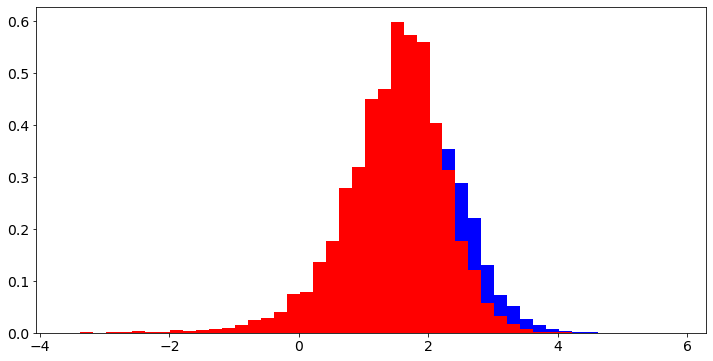

In [140]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)


ax1.hist(verdadeiras['ratio'],density=True,bins=razao_range, color = "blue")
ax1.hist(falsas['ratio'],density=True,bins=razao_range, color = "red")
plt.show()

- Se vimos anteriormente que as notícias negativas tinham uma leve tendência a esquerda, agora temos a mesma visualização para notícias verdadeiras tendendo um pouco mais a direita.

Podemos usar de mais gráficos para enxergar como estão as distribuições por classe.

Uma opção interessante seria o boxplot:

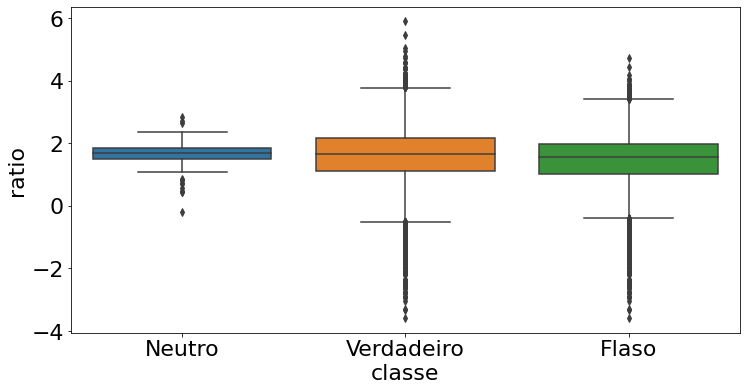

In [144]:
ax = sns.boxplot(x='classe', y='ratio', data=all_count_ratio)
ax.figure.set_size_inches(12,6)
plt.rcParams.update({'font.size': 22})

- Podemos ver como a classe verdadeira está sutilmente acima da classe falsa.

- Mas por mais que possamos ver essa diferença bem sutíl entre as classes, ainda temos uma dificuldade de enxergar e dizer se faz sentido ou não, que palavras presentes em uma notícia podem denotar se a notícia é falsa ou não.

- Podemos então utilizar o lmplot, o mesmo além de plotar a distribuição tende também a mostrar para que lado a distribuição esta crescendo.

Vamos iniciar analisando como as notícias verdadeiras se comportam:

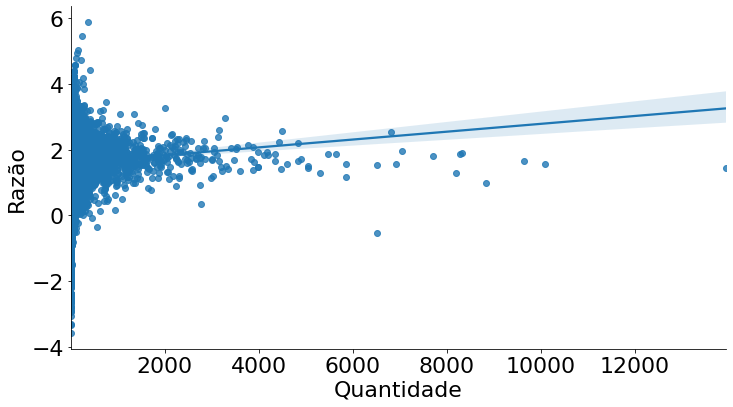

In [146]:
ax = sns.lmplot(x='count', y='ratio', data=verdadeiras)
ax.set(xlabel='Quantidade', ylabel='Razão')
plt.gcf().set_size_inches(12, 6)
plt.rcParams.update({'font.size': 22})

- Como podemos observar a tendência é de que quanto mais ocorrem palavras em uma notícia verdadeira, ela tende a crescer para o lado positivo da razão, com valores acima de 2 se distanciando de forma mais lenta do centro da distribuição, em relação ao histograma que construímos, seria para o lado direito da distribuição. 

Agora vamos olhar a tendência para notícias falsas:

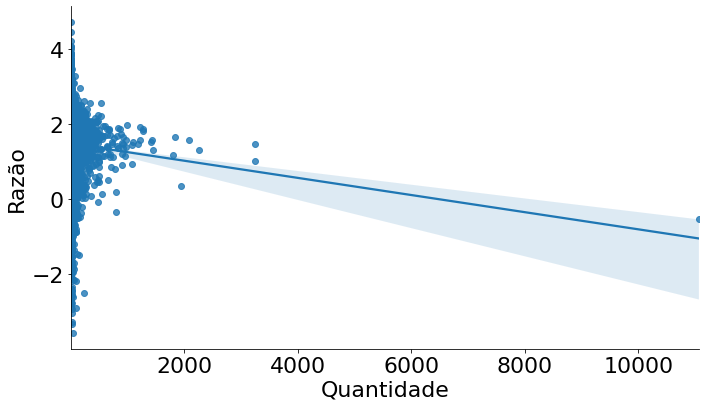

In [147]:
len(falsas)
ax = sns.lmplot(x='count', y='ratio', data=falsas)
ax.set(xlabel='Quantidade', ylabel='Razão')
plt.gcf().set_size_inches(12, 6)
plt.rcParams.update({'font.size': 22})

- Caminha em direção oposta, inidicando que quanto mais palavras ocorrem em uma notícia falsa, mais palavras com menor valor de razão vão surgindo


Podemos também analisar o comportamento das stop words

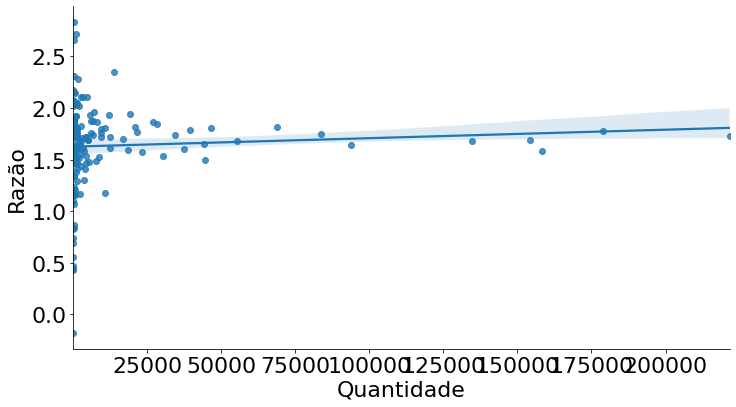

In [148]:
ax = sns.lmplot(x='cont', y='ratio', data=stop)
ax.set(xlabel='Quantidade', ylabel='Razão')
plt.gcf().set_size_inches(12, 6)

plt.rcParams.update({'font.size': 14})

- Como é esperado, as stop words vão continuar acontecendo em ambas as situações, apresentando uma linha quase reta de crescimento. O crescimento leve para cima indica-se mais pelo fator de notícias verdadeiras terem um tamanho mais elevado, mas o crescimento é muito pequeno.


Porem podemos estar sofrendo com algum viés de confirmação. As diferenças apresentadas, podem ser por coincidência, podem não ter relação como imaginamos, podem sofrer de creças iniciais que este trabalho propõe, já que o mesmo busca provar que através de palavras presentes em notícias, podemos identificar uma notícia falsa ou verdadeira.

Para acabar com a dúvida de uma vez por todas, usaremos um cálculo estatístico da biblioteca de estátitisca do `scipy.stats` com a função `ranksums`. Ela tem por intuito dizer se dois conjuntos de medidas (no nosso caso, das razões para notícias verdadeiras e falsas) são derivadas de uma mesma distribuição.

Vamos elaborar duas hipóteses:


**H<sup>null</sup>**
> **A distribuição da razão das palavras é a mesma para notícias verdadeiras e falsas**


**H<sup>alt</sup>**
> **A distribuição da razão das palavras é a mesma para notícias verdadeiras e falsas**

No nosso caso, estamos buscando validar a hipótese alternativa. O que a função ranksums propõe é que devemos aceitar a hipótese alternativa caso o valor do `p-value` seja menor que `0.05`, a diferença entre as duas distribuições seria significativa.

[Link da documentação da função runksums](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html)

In [150]:
from scipy.stats import ranksums
pvalue = ranksums(falsas['ratio'], verdadeiras['ratio']).pvalue

if pvalue < 0.05:
   print('Aceitar a hipótese alternativa')
else:
   print('Aceitar a hipótese nula') 

Aceitar a hipótese alternativa


## Analisando palavras que apresentaram ocorrência em apenas um dos lados

- Abaixo um gráfico com as palavras que mais apareceram em notícias falsas e não apareceram em notícias verdadeiras


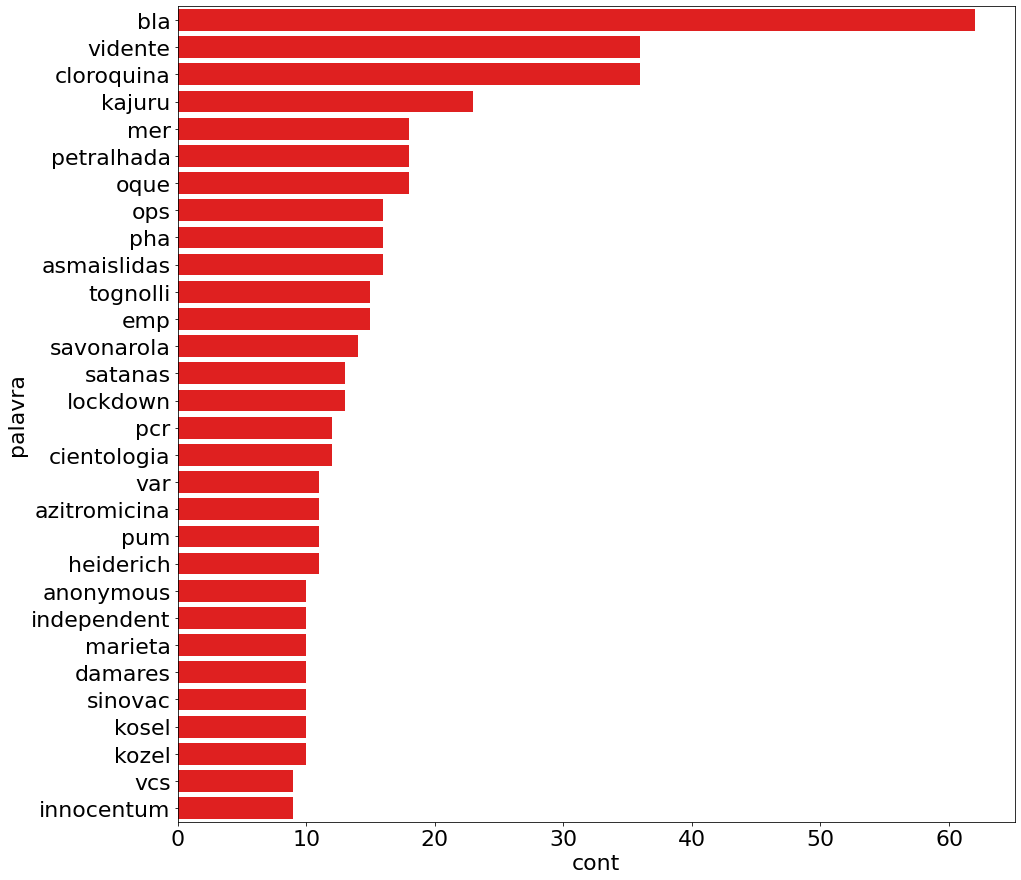

In [178]:
falso_para_verdadeiro = []
for palavra in falso_count.keys():
    if palavra not in verdadeiro_count.keys():
        falso_para_verdadeiro.append({'palavra': palavra, 'cont': falso_count[palavra]})
falso_para_verdadeiro = pd.DataFrame(falso_para_verdadeiro)
falso_para_verdadeiro.sort_values(by='cont', ascending=False)[0:20]

falso_para_verdadeiro.sort_values(by='cont', ascending=False, inplace=True)
plt.rcParams.update({'font.size': 22})
ax = sns.barplot(y='palavra', x='cont', data=falso_para_verdadeiro[:30],  color='red')
plt.gcf().set_size_inches(15, 15)

- É possível notar a presença de palavras escritas com grafia incorreta, palavras abreviadas típicas de redes sociais como "vcs" e palavras de linguagem mais coloquial

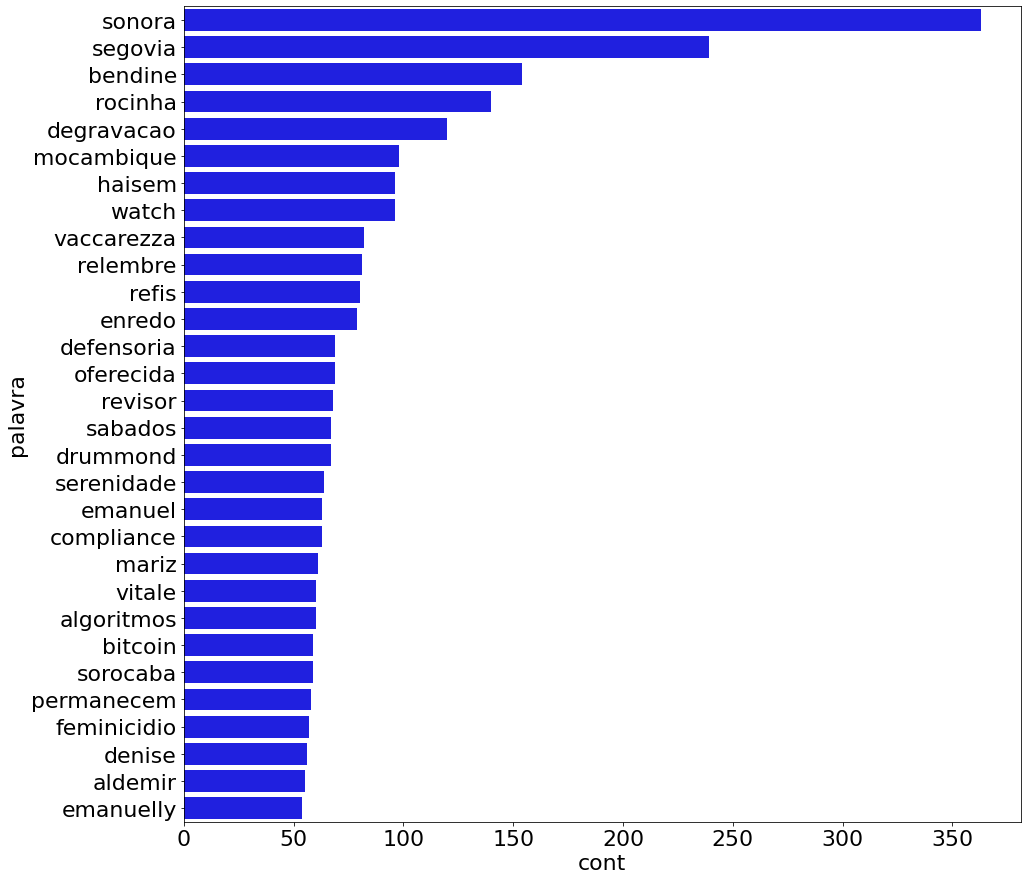

In [179]:
verdadeiro_para_falso = []
for palavra in verdadeiro_count.keys():
    if palavra not in falso_count.keys():
        verdadeiro_para_falso.append({'palavra': palavra, 'cont': verdadeiro_count[palavra]})
verdadeiro_para_falso = pd.DataFrame(verdadeiro_para_falso)
verdadeiro_para_falso.sort_values(by='cont', ascending=False)[0:20]

verdadeiro_para_falso.sort_values(by='cont', ascending=False, inplace=True)
ax = sns.barplot(y='palavra', x='cont', data=verdadeiro_para_falso[:30], color='blue')
plt.gcf().set_size_inches(15, 15)

- Já para notícias verdadeiras não encontramos palavras com linguajar mais coloquial, e nem erros de grafia. 

### Conclusão da análise

- Dentro desta análise pudemos notar que notícias os seguintes fatores:

Notícias verdadeiras tem tamanho maior que notícias falsas, que notícias falsas tem linguajar podem utilizar de linguajar mais coloquial e abreviações alem de mais erros de grafia, e também podemos notar uma diferença na distribuição da razão entre palavras onde notícias verdadeiras e falsas tendem a ter razões tendendo a direções distintas.

## Construindo um modelo

- Funções utilitárias

In [ ]:
def formatar_lote_de_noticias(noticias):
    lote = []
    for i, linha in noticias.iterrows():
        contagem = dict.fromkeys(vocabulario, 0)
        palavras = linha['texto'].split()
        
        for palavra in palavras:
            contagem[palavra] += 1
        lote.append(contagem)
    
    return pd.DataFrame(lote)

In [ ]:
def formatar_lote_de_noticias_sim_nao(noticias):
    lote = []
    for i, linha in noticias.iterrows():
        contagem = dict.fromkeys(vocabulario, 0)
        palavras = linha['texto'].split()
        
        for palavra in palavras:
            contagem[palavra] = 1
        lote.append(contagem)
    
    return pd.DataFrame(lote)

In [ ]:
def format_labels(y_train):
    rows = []
    for value in y_train:
        if value == 0:
            rows.append([0,1])
        else:
            rows.append([1,0])
    return rows

In [ ]:
def classificar_noticia(est, noticia):
    classe = est.predict(formatar_lote_de_noticias(pd.DataFrame([{'texto':noticia}])))[0]
    return 'Verdadeiro' if classe == 1 else 'Falso'

In [ ]:
def classify(result):
    if(result[0] == 0 and result[1] == 1):
        return 0
    else:
        return 1

- Construção dos modelos

In [ ]:
tamanho_lote = 128

In [ ]:
noticia = 'cloroquina salva milhoes em tratamento precoce'

In [ ]:
noticias, classes = todas_noticias['texto'].to_frame(),todas_noticias['classificacao'].to_frame()

In [ ]:
classes.classificacao = classes.classificacao.map(lambda x: 0 if x == 'falso' else 1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(noticias, classes['classificacao'].array, random_state=42)

validacao_treino, validacao_classe = X_test[:2*tamanho_lote], y_test[:2*tamanho_lote]

X_test, y_test = X_test[2*tamanho_lote:], y_test[2*tamanho_lote:]

In [ ]:
len(X_test)

In [ ]:
x_test = formatar_lote_de_noticias(X_test)

In [ ]:
x_test_sn = formatar_lote_de_noticias_sim_nao(X_test)

In [ ]:
x_test_batch = formatar_lote_de_noticias(X_test[0:128]).to_numpy()
y_test_batch = np.asanyarray(format_labels(y_test[0:128].to_numpy()))

In [ ]:
val_formated = formatar_lote_de_noticias(validacao_treino).to_numpy()
val_formated_class = np.asanyarray(format_labels(validacao_classe.to_numpy()))

In [ ]:
val_formated_sn = formatar_lote_de_noticias_sim_nao(validacao_treino).to_numpy()
val_formated_class_sn = np.asanyarray(format_labels(validacao_classe.to_numpy()))

In [ ]:
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

target_names = ['Falso', 'Verdadeiro']

### Importando modelos utilizados

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import PassiveAggressiveClassifier
from keras.models import load_model
import tensorflow as tf

In [ ]:
stats = []

## SGD Classifier

- Testando modelo SGD Classifier

In [ ]:


est = SGDClassifier(loss='log', penalty='l2', tol=1e-3)

## Treinando

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    est.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = est.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo SGD

In [ ]:
joblib.dump(est, 'sgd.sav')

### Carregar modelo SGD

In [ ]:
sgd_model = joblib.load('sgd.sav')

- Classificar usando modelo SGD

In [ ]:
classificar_noticia(sgd_model, noticia)

- Resultados do modelo

In [ ]:
sgd_model.score(x_test, y_test)

## Confusion Matrix

In [ ]:
sgd_pred = sgd_model.predict(x_test)

confusion_matrix(y_test, sgd_pred)

## Accuracy Score

In [ ]:
set(sgd_pred)
set(y_test)

In [ ]:
accuracy_score(y_test, sgd_pred)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
precision,recall,fscore,support=score(y_test,sgd_pred,average='macro')
print('Precision : {}'.format(precision))
print('Recall    : {}'.format(recall))
print('F-score   : {}'.format(fscore))
print('Support   : {}'.format(support))

## Classification Report

In [ ]:
report = classification_report(y_test, sgd_pred, target_names=target_names,  output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'sgd_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## SGD Classifier em dados de sim ou não

In [ ]:
est_sn = SGDClassifier(loss='log', penalty='l2', tol=1e-3)

## Treinando

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    est_sn.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = est_sn.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo SGD (contains)

In [ ]:
joblib.dump(est_sn, 'sgdsn.sav')

### Carregar modelo SGD (contains)

In [ ]:
sgdsn_model_sn = joblib.load('sgdsn.sav')

- Classificar usando modelo SGD (contains)

In [ ]:
classificar_noticia(sgdsn_model_sn, noticia)

- Resultados do modelo





In [ ]:
sgdsn_model_sn.score(x_test_sn, y_test)

## Confusion Matrix

In [ ]:
sgdsn_pred = sgdsn_model_sn.predict(x_test_sn)

confusion_matrix(y_test, sgdsn_pred)

## Accuracy Score

In [ ]:
accuracy_score(y_test, sgdsn_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, sgdsn_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'sgd_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## MultinomialNB

In [ ]:
clf = MultinomialNB()
## Treinando
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    clf.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = clf.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo MultinomialNB

In [ ]:
joblib.dump(est_sn, 'MultinomialNB.sav')

### Carregar modelo MultinomialNB

In [ ]:
multinb_model = joblib.load('MultinomialNB.sav')

- Classificar usando modelo MultinomialNB

In [ ]:
classificar_noticia(multinb_model, noticia)

- Resultados do modelo

In [ ]:
multinb_model.score(x_test, y_test)

## Confusion Matrix

In [ ]:
multinb_model_pred = multinb_model.predict(x_test)

confusion_matrix(y_test, multinb_model_pred)

## Accuracy Score

In [ ]:
accuracy_score(y_test, multinb_model_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, multinb_model_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'multinomial_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## MultiomailNB Classifier em dados de sim ou não

In [ ]:
clf_sn = MultinomialNB()

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    clf_sn.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = clf_sn.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo MultinomialNB

In [ ]:
joblib.dump(est_sn, 'MultinomialNBSN.sav')

### Carregar modelo MultinomialNB

In [ ]:
multinb_model_sn = joblib.load('MultinomialNB.sav')

- Classificar usando modelo MultinomialNB

In [ ]:
classificar_noticia(multinb_model_sn, noticia)

- Resultados do modelo

In [ ]:
multinb_model_sn.score(x_test, y_test)

## Confusion Matrix

In [ ]:
multinb_model_pred_sn = multinb_model_sn.predict(x_test_sn)
confusion_matrix(y_test, multinb_model_pred_sn)

## Accuracy Score

In [ ]:
accuracy_score(y_test, multinb_model_pred_sn)

## Classification Report

In [ ]:
report = classification_report(y_test, multinb_model_pred_sn, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'multinomial_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

# Perceptron

In [ ]:
percep = Perceptron()

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    percep.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = percep.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Perceptron

In [ ]:
joblib.dump(percep, 'Percep.sav')

### Carregar modelo Perceptron


In [ ]:
perceb_model = joblib.load('Percep.sav')

- Classificar usando modelo Perceptron

In [ ]:
classificar_noticia(perceb_model, noticia)

- Resultados do modelo

In [ ]:
perceb_model.score(x_test, y_test)


## Confusion Matrix

In [ ]:
perceb_model_pred = perceb_model.predict(x_test)
confusion_matrix(y_test, perceb_model_pred)

## Accuracy Score

In [ ]:

accuracy_score(y_test, perceb_model_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, perceb_model_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'percep_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Perceptron sim ou não

In [ ]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    percep_sn.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = percep_sn.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Perceptron

In [ ]:
joblib.dump(percep_sn, 'percep_sn.sav')

### Carregar modelo Perceptron

In [ ]:
perceb_model_sn = joblib.load('percep_sn.sav')

- Classificar usando modelo Perceptron

In [ ]:
classificar_noticia(perceb_model_sn, noticia)

- Resultados do modelo

In [ ]:
perceb_model_sn.score(x_test_sn, y_test)

## Confusion Matrix

In [ ]:
perceb_model_pred_sn = perceb_model_sn.predict(x_test_sn)
confusion_matrix(y_test, perceb_model_pred_sn)

## Accuracy Score


In [ ]:
accuracy_score(y_test, perceb_model_pred_sn)

## Classification Report

In [ ]:
report = classification_report(y_test, perceb_model_pred_sn, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'percep_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Bernouli

In [ ]:
bern_count = BernoulliNB()
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    bern_count.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = bern_count.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Perceptron

In [ ]:
joblib.dump(percep_sn, 'bernouli.sav')

### Carregar modelo Perceptron

In [ ]:
bern_model = joblib.load('bernouli.sav')

- Classificar usando modelo Perceptron

In [ ]:
classificar_noticia(bern_model, noticia)

- Resultados do modelo

In [ ]:
bern_model.score(x_test, y_test)

## Confusion Matrix

In [ ]:
bern_model_pred = bern_model.predict(x_test)
confusion_matrix(y_test, bern_model_pred)

## Accuracy Score

In [ ]:
accuracy_score(y_test, bern_model_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, bern_model_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'bernouli_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

In [ ]:
stats

## Bernouli Sim ou Não

In [ ]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    bern.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = bern.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Bernouli

In [ ]:
joblib.dump(bern, 'bernoulisn.sav')

### Carregar modelo Perceptron

In [ ]:
bern_model_sn = joblib.load('bernoulisn.sav')

- Classificar usando modelo Perceptron

In [ ]:
classificar_noticia(bern_model_sn, noticia)

- Resultados do modelo

In [ ]:
bern_model_sn.score(x_test_sn, y_test)

## Confusion Matrix

In [ ]:
bern_model_sn_pred = bern_model_sn.predict(x_test_sn)
confusion_matrix(y_test, bern_model_sn_pred)

## Accuracy Score

In [ ]:
accuracy_score(y_test, bern_model_sn_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, bern_model_sn_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'benouli_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Passive agressive classifier

In [ ]:
passive = PassiveAggressiveClassifier()

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    passive.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = passive.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Passive Agressive

In [ ]:
joblib.dump(passive, 'passive.sav')

### Carregar modelo Passive Agressive

In [ ]:
passive_model = joblib.load('passive.sav')

- Classificar usando modelo Passive Agressive

In [ ]:
classificar_noticia(passive_model, noticia)

- Resultados do modelo

In [ ]:
passive_model.score(x_test, y_test)

## Confusion Matrix

In [ ]:
passive_model_pred = passive_model.predict(x_test)
confusion_matrix(y_test, passive_model_pred)

## Accuracy Score

In [ ]:
accuracy_score(y_test, passive_model_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, passive_model_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'passive_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)


## Passive agressive classifier Sim Não

In [ ]:
passive_sn = PassiveAggressiveClassifier()

inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1
while True:
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    passive_sn.partial_fit(x_train, y_train[inicio_lote:fim_lote], classes=[0,1])
    score = passive_sn.score(formatar_lote_de_noticias(validacao_treino), validacao_classe)
    
    print(f'Lote {i} of {total_lotes} - score: {score}')
    time.sleep(0.10)
    
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Passive Agressive

In [ ]:
joblib.dump(passive_sn, 'passivesn.sav')

### Carregar modelo Perceptron

In [ ]:
passive_model_sn = joblib.load('passivesn.sav')

- Classificar usando modelo Perceptron

In [ ]:
classificar_noticia(passive_model_sn, noticia)

- Resultados do modelo

In [ ]:
passive_model_sn.score(x_test_sn, y_test)

## Confusion Matrix

In [ ]:
passive_model_sn_pred = passive_model_sn.predict(x_test_sn)
confusion_matrix(y_test, passive_model_sn_pred)

## Accuracy Score

In [ ]:
accuracy_score(y_test, passive_model_sn_pred)

## Classification Report

In [ ]:
report = classification_report(y_test, passive_model_sn_pred, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'passive_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Redes Neurais

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_dim=82080),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

lossss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)

model.compile(optimizer='adam',
              loss=lossss,
              metrics=['accuracy'])

In [ ]:


inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1

# model.save('keras_count.h5')
while True:
#     /model = load_model('keras_count.h5')
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    y_tr = np.asanyarray(format_labels(y_train[inicio_lote:fim_lote].to_numpy()))
    model.fit(x_train.to_numpy(), y_tr, epochs=10)
#     model.save('keras_count.h5')
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

- Avaliando o modelo

### Exportando o modelo Rede Neural

In [ ]:
model.save('keras_finished_count_2.h5')

### Carregar modelo Rede Neural

In [ ]:
keras_model = load_model('keras_finished_count_2.h5')

- Resultados do modelo


In [ ]:
score, acc = keras_model.evaluate(x_test_batch, y_test_batch)
print(f"Score: {score}")
print(f"Accuracy: {acc}")

## Confusion Matrix

In [ ]:
y_pred_keras = keras_model.predict(x_test.to_numpy()).round()
y_pred_keras = [classify(result) for result in y_pred_keras]
confusion_matrix(y_test, y_pred_keras)

## Accuracy Score

In [ ]:
accuracy_score(y_test, y_pred_keras)

## Classification Report

In [ ]:
report = classification_report(y_test, y_pred_keras, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'keras_count', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Keras Contains

In [ ]:
model_contains = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_dim=82080),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

lossss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)

model_contains.compile(optimizer='adam',
              loss=lossss,
              metrics=['accuracy'])

In [ ]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1

# model.save('keras_count.h5')
while True:
#     /model = load_model('keras_count.h5')
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    y_tr = np.asanyarray(format_labels(y_train[inicio_lote:fim_lote].to_numpy()))
    model_contains.fit(x_train.to_numpy(), y_tr, epochs=10)
#     model.save('keras_count.h5')
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

### Exportando o modelo Rede Neural

In [ ]:
model_contains.save('keras_finished_contains_2.h5')

### Carregar modelo Rede Neural

In [ ]:
keras_model_sn = load_model('keras_finished_contains_2.h5')

- Resultados do modelo

In [ ]:
score, acc = keras_model_sn.evaluate(x_test_batch, y_test_batch)
print(f"loss: {score}")
print(f"Accuracy: {acc}")

## Confusion Matrix

In [ ]:
y_pred_keras_sn = keras_model_sn.predict(x_test_sn.to_numpy()).round()
y_pred_keras_sn = [classify(result) for result in y_pred_keras_sn]
confusion_matrix(y_test, y_pred_keras_sn)

## Accuracy Score

In [ ]:
accuracy_score(y_test, y_pred_keras_sn)

## Classification Report

In [ ]:
report = classification_report(y_test, y_pred_keras_sn, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'keras_contains', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Keras Contains Validation

In [ ]:
model_ = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_dim=82080),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

lossss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)

model_.compile(optimizer='adam',
              loss=lossss,
              metrics=['accuracy'])

In [ ]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1

# model.save('keras_count.h5')
while True:
#     /model = load_model('keras_count.h5')
    x_train = formatar_lote_de_noticias(X_train[inicio_lote:fim_lote])
    y_tr = np.asanyarray(format_labels(y_train[inicio_lote:fim_lote].to_numpy()))
    model_.fit(x=x_train.to_numpy(), y=y_tr, validation_data=(val_formated, val_formated_class), epochs=10)
#     model.save('keras_count.h5')
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

### Exportando o modelo Rede Neural

In [ ]:
model_.save('keras_finished_count_val_2.h5')

### Carregar modelo Rede Neural

In [ ]:
keras_model_val = load_model('keras_finished_count_val_2.h5')

- Resultados do modelo

In [ ]:
score, acc = keras_model_val.evaluate(x_test_batch, y_test_batch)
print(f"Score: {score}")
print(f"Accuracy: {acc}")

## Confusion Matrix

In [ ]:
y_pred_keras_val = keras_model_val.predict(x_test.to_numpy()).round()
y_pred_keras_val = [classify(result) for result in y_pred_keras_val]
confusion_matrix(y_test, y_pred_keras_val)

## Accuracy Score

In [ ]:
accuracy_score(y_test, y_pred_keras_val)

## Classification Report

In [ ]:
report = classification_report(y_test, y_pred_keras_val, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'keras_count_val', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

## Keras Contains Validation Sim/Não

In [ ]:
model_sn = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_dim=82080),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

lossss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)

model_sn.compile(optimizer='adam',
              loss=lossss,
              metrics=['accuracy'])

In [ ]:
inicio_lote = 0
fim_lote = tamanho_lote

total_lotes = str(int(len(X_train)/tamanho_lote))
ultimo_lote = False
i = 1

# model.save('keras_count.h5')
while True:
#     /model = load_model('keras_count.h5')
    x_train = formatar_lote_de_noticias_sim_nao(X_train[inicio_lote:fim_lote])
    y_tr = np.asanyarray(format_labels(y_train[inicio_lote:fim_lote].to_numpy()))
    model_sn.fit(x=x_train.to_numpy(), y=y_tr, validation_data=(val_formated_sn, val_formated_class_sn), epochs=10)
#     model.save('keras_count.h5')
    inicio_lote += tamanho_lote
    
    if fim_lote + tamanho_lote > len(X_train):
        fim_lote = len(X_train)
        ultimo_lote = True
    else:
        fim_lote += tamanho_lote
    
    i += 1
    if ultimo_lote:
        break

### Exportando o modelo Rede Neural

In [ ]:
model_sn.save('keras_model_sn_val_2.h5')

### Carregar modelo Rede Neural

In [ ]:
keras_model_val_sn = load_model('keras_model_sn_val.h5')

- Resultados do modelo

In [ ]:
score, acc = keras_model_val_sn.evaluate(x_test_batch, y_test_batch)
print(f"loss: {score}")
print(f"Accuracy: {acc}")

## Confusion Matrix

In [ ]:
y_pred_keras_sn_val = model_sn.predict(x_test_sn.to_numpy()).round()
y_pred_keras_sn_val = [classify(result) for result in y_pred_keras_sn_val]
confusion_matrix(y_test, y_pred_keras_sn_val)

## Accuracy Score

In [ ]:
accuracy_score(y_test, y_pred_keras_sn_val)

## Classification Report

In [ ]:
report = classification_report(y_test, y_pred_keras_sn_val, target_names=target_names, output_dict=True)
report

In [ ]:
sgd_stats = {'model': 'keras_contains_val', 
            'accuracy': report['accuracy'], 
            'recall': report['macro avg']['recall'], 
            'f1_score': report['macro avg']['f1-score'],
            'support': report['macro avg']['support'],
            'falso_precision': report['Falso']['precision'],
            'falso_recall': report['Falso']['recall'],
            'falso_f1_score': report['Falso']['f1-score'],
            'verdadeiro_precision': report['Verdadeiro']['precision'],
            'verdadeiro_recall': report['Verdadeiro']['recall'],
            'verdadeiro_f1_score': report['Verdadeiro']['f1-score']}
sgd_stats

In [ ]:
stats.append(sgd_stats)

In [ ]:
stats_df = pd.DataFrame(stats)

In [ ]:
stats_df

In [ ]:
stats_df.to_csv('model_stats.csv')

In [ ]:
stats_df.accuracy = stats_df.accuracy.map(lambda i:i*100)

In [ ]:
stats_df.recall = stats_df.recall.map(lambda i:i*100)
stats_df.f1_score = stats_df.f1_score.map(lambda i:i*100)
stats_df.support = stats_df.support.map(lambda i:i*100)
stats_df.falso_precision = stats_df.falso_precision.map(lambda i:i*100)
stats_df.falso_recall = stats_df.falso_recall.map(lambda i:i*100)
stats_df.falso_f1_score = stats_df.falso_f1_score.map(lambda i:i*100)
stats_df.verdadeiro_precision = stats_df.verdadeiro_precision.map(lambda i:i*100)
stats_df.verdadeiro_recall = stats_df.verdadeiro_recall.map(lambda i:i*100)
stats_df.verdadeiro_f1_score = stats_df.verdadeiro_f1_score.map(lambda i:i*100)

In [ ]:
stats_df.to_csv('model_stats_formatted.csv')

In [ ]:
stats_df = pd.read_csv('model_stats_formatted.csv')

In [ ]:
stats_df.head()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'accuracy', data=stats_df.sort_values(['accuracy'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Acurácia", size=14)
plt.savefig("acurácia modelos.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,100)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'recall', data=stats_df.sort_values(['recall'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Recall", size=14)
plt.savefig("acurácia modelos.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,100)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'f1_score', data=stats_df.sort_values(['f1_score'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("F1 Score", size=14)
plt.savefig("acurácia modelos.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,100)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'verdadeiro_precision', data=stats_df.sort_values(['verdadeiro_precision'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Precisão Verdadeiro", size=14)
plt.savefig("acurácia modelos.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'falso_precision', data=stats_df.sort_values(['falso_precision'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Precisão Falso", size=14)
plt.savefig("Precisão Falso.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

In [ ]:
		verdadeiro_recall	

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'falso_f1_score', data=stats_df.sort_values(['falso_f1_score'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Falso F1 Score", size=14)
plt.savefig("Precisão Falso.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'verdadeiro_precision', data=stats_df.sort_values(['verdadeiro_precision'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Verdadeiro F1 Score", size=14)
plt.savefig("Precisão Falso.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'verdadeiro_recall', data=stats_df.sort_values(['verdadeiro_recall'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Verdadeiro Recall", size=14)
plt.savefig("Verdadeiro Recall.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()

In [ ]:
plt.xticks(rotation=75)
g = sns.barplot(x='model', y = 'falso_recall', data=stats_df.sort_values(['falso_recall'], ascending=False))
for p in g.patches:
    g.annotate(str(format(p.get_height(), '.1f')) + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Modelos", size=14)
plt.ylabel("Falso Recall", size=14)
plt.savefig("Falso Recall.png")
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylim(1,110)
plt.show()